In [1]:
from pathlib import Path
import json
from collections import defaultdict

In [2]:
import cv2
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import torch
import torchvision
from torch.utils.data import Dataset
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.io import read_image
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda

In [3]:
torchvision.__version__

'0.10.0+cu111'

In [4]:
torch.__version__

'1.9.0+cu111'

In [5]:
# data_dir = Path(r"C:\datasets\pubtabnet")
data_dir = Path(r"C:\Users\stans\Documents\Projects\Datasets\pubtabnet.tar\pubtabnet\pubtabnet")
train_dir = data_dir / "train"

In [6]:
publaynet_images = list(train_dir.glob("*.png"))
with open(data_dir/'targets.json','r') as f:
    publaynet_targets = json.load(f)

In [33]:
def resize_input(img, labels, shape):
    arr = np.zeros(shape)
    # img = ImageOps.grayscale(img)
    _, wt, ht = shape
    w,h = img.size
    wscale = wt/w
    hscale = ht/h
    scale = min(wscale, hscale)
    new_shape = round(w*scale),round(h*scale)
    img = img.resize(new_shape)
    w,h = new_shape
    arr[:,:w,:h] = np.array(img).T/255
    
    labels = [
        [
            round(x1*scale),
            round(y1*scale),
            round(x2*scale),
            round(y2*scale),
        ] for x1,y1,x2,y2 in labels
    ]
    
    
    return torch.as_tensor(arr,dtype=torch.float32), labels

def resize_labels(boxes, size):
    out_boxes = np.zeros((size, 4))
    out_boxes[:len(boxes),:] = np.array(boxes)
    labels = [1 for b in boxes] + [0 for i in range(size-len(boxes))]
    return {
        'boxes': torch.as_tensor(out_boxes).to(torch.double),
        'labels': torch.as_tensor(labels),
    }
    

def test_resizer(i):
    img = Image.open(publaynet_images[i])
    trg = publaynet_targets[publaynet_images[i].name]
    im, l = resize_input(img, trg, (3, 256, 128))
    im = im[1]
    for x1,y1,x2,y2 in l:
        im[x1:x2,y1:y2] = 0
    plt.imshow(im.T)
    
def get_sized_input(img_path):
    image = Image.open(img_path)
    boxes = publaynet_targets[img_path.name]
    image, boxes = resize_input(image, boxes, (3, 256, 128))
    return image, {
        'boxes': torch.as_tensor(boxes),
        'labels': torch.ones(len(boxes),dtype=torch.int64),
    }

def load_batch(paths):
    X = []
    y = []
    for img_path in paths:
        i,l = get_sized_input(img_path)
        X.append(i)
        y.append(l)
    return X,y

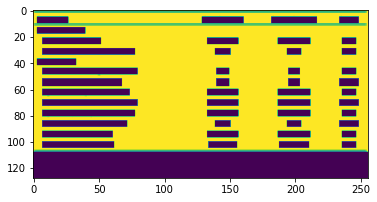

In [29]:
test_resizer(1)

In [10]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    pretrained=False,
    num_classes=3,
)

In [11]:
def train_loop(files, batch_size, model):
    size = len(files)
    for batch in range(size//batch_size):
        im_paths = files[batch*batch_size : (batch+1)*batch_size]
        X,y = load_batch(im_paths)
        # Compute prediction and loss
        output = model(X, y)

        if batch % 100 == 0:
            current = (1+batch)*batch_size
            print(f"{current}/{size}".center(40,'-'))
            for k,v in output.items():
                print(f"{k}{' '*(20-len(k))}{v}")

In [12]:
batch_size = 8
epochs = 5

In [13]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(publaynet_images[:100000], batch_size, model)
print("Done!")

Epoch 1
-------------------------------


C:\Users\stans\Documents\Projects\git\PubTabNet\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------8/100000----------------
loss_classifier     1.1542742252349854
loss_box_reg        0.09382998943328857
loss_objectness     14.806461334228516
loss_rpn_box_reg    17.70360565185547
---------------808/100000---------------
loss_classifier     1.3029613494873047
loss_box_reg        0.10599565505981445
loss_objectness     12.591653823852539
loss_rpn_box_reg    15.758830070495605


KeyboardInterrupt: 

In [14]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [34]:
X,y = load_batch(publaynet_images[:4])

In [36]:
output = model(X)

In [37]:
output

[{'boxes': tensor([[1.0069e+00, 4.6626e+00, 3.5818e+01, 2.5600e+02],
          [1.2897e-01, 1.3254e+02, 3.5607e+01, 2.5410e+02],
          [3.6276e+00, 1.8933e+00, 3.5693e+01, 1.3124e+02]],
         grad_fn=<StackBackward>),
  'labels': tensor([84, 84, 84]),
  'scores': tensor([0.3589, 0.2282, 0.1798], grad_fn=<IndexBackward>)},
 {'boxes': tensor([[  4.7517, 234.6378,   8.4799, 249.2801]], grad_fn=<StackBackward>),
  'labels': tensor([1]),
  'scores': tensor([0.0886], grad_fn=<IndexBackward>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward>)},
 {'boxes': tensor([[  0.0000,  80.5138, 126.0287, 218.7097],
          [  0.0000,  81.0972, 128.0000, 218.2976],
          [  3.9727,  37.0634, 121.5375, 217.3656],
          [  0.0000,  19.6837, 128.0000, 226.0392],
          [  6.9411, 180.0009, 122.7949, 221.9931]], grad_fn=<StackBackward>),
  'labels': tensor([73, 72, 75, 82, 75]),
  'score

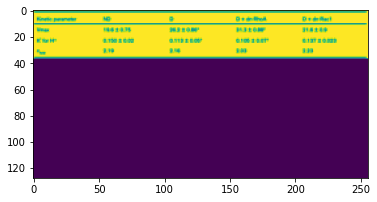

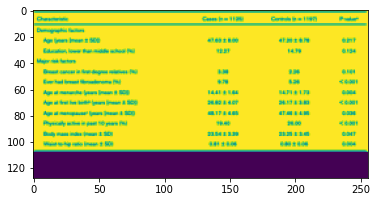

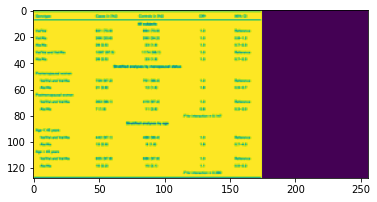

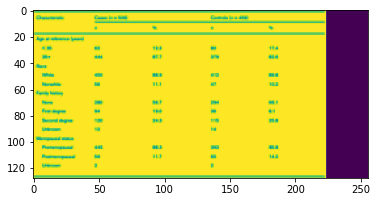

In [38]:
for x in X:
    plt.imshow(np.array(x[0]).T)
    plt.show()